In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from tqdm import tqdm

random.seed(2022)
np.random.seed(2022)
plt.style.use("ggplot")

In [2]:
class DataLoader:
    def __init__(self, X, y, batch_size, shuffle=True):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        size = self.y.shape[0]
        size_batch = size // self.batch_size
        if size_batch <= 0:
            return 1
        return size_batch

    def __getitem__(self, i):
        i_start = i * self.batch_size
        i_end = (i + 1) * self.batch_size
        X_batch = self.X[i_start:i_end]
        y_batch = self.y[i_start:i_end]
        if y_batch.shape[0] <= 0:
            if self.shuffle:
                idx = np.arange(self.y.shape[0])
                permutation = np.random.permutation(idx)
                self.X = self.X[idx]
                self.y = self.y[idx]
            raise IndexError("End of item")
        return X_batch, y_batch


100%|██████████| 50/50 [00:00<00:00, 284.65it/s, loss=1,573.6818]


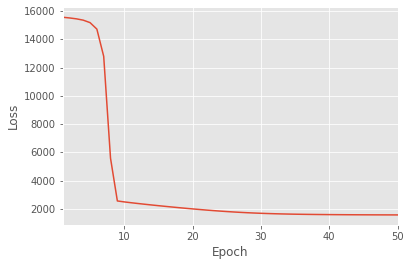

In [3]:
data = load_diabetes()
X, y = data["data"], data["target"]

X_min, X_max = np.min(X, 0), np.max(X, 0)

X = (X - X_min) / (X_max - X_min)

# Dataloader hyperparameters
batch_size = 32
shuffle = True

# Training hyperparameters
epoch = 50
lr = 1e-4
weight_decay = 1e-5

# Dataloader
dataloader = DataLoader(X, y, batch_size, shuffle)

# Model
W1 = np.random.lognormal(size=(X.shape[-1], 32)).astype(np.float32) * 1e-2
b1 = np.random.lognormal(size=(32,)).astype(np.float32) * 1e-2

W2 = np.random.lognormal(size=(32, 64)).astype(np.float32) * 1e-2
b2 = np.random.lognormal(size=(64,)).astype(np.float32) * 1e-2

W3 = np.random.lognormal(size=(64, 1)).astype(np.float32) * 1e-2
b3 = np.random.lognormal(size=(1)).astype(np.float32) * 1e-2

result = []
pbar = tqdm(range(1, epoch + 1))
for i in pbar:
    loss_epoch = 0
    for x_train, y_train in dataloader:
        # Forward pass
        bmm1 = np.einsum("bi,io->bo", x_train, W1)
        add1 = bmm1 + b1

        bmm2 = np.einsum("bi,io->bo", add1, W2)
        add2 = bmm2 + b2

        bmm3 = np.einsum("bi,io->bo", add2, W3)
        add3 = bmm3 + b3

        # Calculate loss (MSE)
        diff = add3 - y_train[:, None]
        loss = np.mean(np.square(diff)) / 2

        # Backward pass
        size = x_train.shape[0]
        out3_grad = diff / size

        b3_grad = np.einsum("o,bo->o", np.ones_like(b3), out3_grad)
        W3_grad = np.einsum("bi,bo->io", bmm2, out3_grad)

        out2_grad = np.einsum("io,bo->bi", W3, out3_grad)

        b2_grad = np.einsum("o,bo->o", np.ones_like(b2), out2_grad)
        W2_grad = np.einsum("bi,bo->io", bmm1, out2_grad)

        out1_grad = np.einsum("io,bo->bi", W2, out2_grad)

        b1_grad = np.einsum("o,bo->o", np.ones_like(b1), out1_grad)
        W1_grad = np.einsum("bi,bo->io", x_train, out1_grad)

        # Optimize (SGD)

        # Regularize
        b3_grad += b3 * weight_decay
        W3_grad += W3 * weight_decay

        b2_grad += b2 * weight_decay
        W2_grad += W2 * weight_decay

        b1_grad += b1 * weight_decay
        W1_grad += W1 * weight_decay

        # Update parameters
        b3 -= lr * b3_grad
        W3 -= lr * W3_grad

        b2 -= lr * b2_grad
        W2 -= lr * W2_grad

        b1 -= lr * b1_grad
        W1 -= lr * W1_grad

        # Record batch-wise loss
        loss_epoch += loss

    loss_epoch = loss_epoch / len(dataloader)

    # Add epoch loss to progress bar
    pbar.set_postfix(loss=f"{loss_epoch:,.4f}")

    # Record batch-wise mean loss
    result.append(loss_epoch)

plt.plot(range(1, epoch + 1), result)
plt.xlabel("Epoch")
plt.xlim(1, epoch)
plt.ylabel("Loss")
plt.show()
